In [1]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (16,7)
mpl.rcParams["image.origin"] = "lower"
mpl.rcParams["image.interpolation"] = "nearest"

from astropy.io import fits
from astropy.table import Table

# pysynphot for adjusting spectrum template
import pysynphot as S

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/keith/PYSYN_CDBS/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
# functions_list = [find_object, load_spec, print_cutout]

# Define slice dimensions
half_slice_width = 3 # x width
half_slice_length = 500 # y length
wave = np.linspace(10000, 20000, 2*half_slice_length+1) # wavelength array

# Read in catalog
hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format='ascii')
hlss_tbl = hlss_tbl.group_by("MODIMAGE")
hlss_tbl.groups[0].sort("MAG_F1500W", reverse=True)
hlss_tbl.groups[1].sort("MAG_F1500W", reverse=True)

# Read in sensitivity and bandpass files
sens = Table.read("/Users/keith/astr/research_astr/summer-roman-project/toy_configs/sens_0720_2020.fits", format="fits")
interpolated_sens = np.interp(wave, sens["WAVELENGTH"], sens["SENSITIVITY"])

df = Table.read("/Users/keith/astr/research_astr/FOV0/FOV0_SEDs/wfirst_wfi_f158_001_syn.fits", format='fits')
bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

SED_dir = "/Users/keith/astr/research_astr/FOV0/FOV0_SEDs" # Define SED directory

# Extract spectrum from model
file = fits.open("/Users/keith/astr/research_astr/summer-roman-project/predictable_extract/fits/straight_line_model.fits")
data = file[1].data
file.close()



In [3]:
def find_object(x, y, distance):
    condition = (abs(hlss_tbl["X_IMAGE"] - x) <= distance) & (abs(hlss_tbl["Y_IMAGE"] - y) <= distance)
    object = hlss_tbl[np.where(condition)][0]
    return object

def load_template(object):
    SPECTEMP = object["SPECTEMP"]
    Z = object["Z"]
    mag = object["MAG_F1500W"]
    sed = "SED:rest:gal.{0}.fits".format(SPECTEMP)

    data = Table.read(os.path.join(SED_dir, sed), format='fits')

    template = S.ArraySpectrum(data["wavelength"], data["flux"], waveunits="angstroms", fluxunits="flam").redshift(Z)
    template = template.renorm(mag, "abmag", bp)
    template.convert("flam")
    return template

def print_cutout(object):
    x_0 = object["X_IMAGE"]
    y_0 = object["Y_IMAGE"]

    fig, (ax1, ax2) = plt.subplots(1, 2)

    vmin=0 ; vmax=1

    ax1.imshow(data, vmin=vmin, vmax=vmax, cmap="Greys_r")
    ax1.axvline(x_0 - half_slice_width - 5)
    ax1.axvline(x_0 + half_slice_width + 5)
    ax1.axhline(y_0 - half_slice_length)
    ax1.axhline(y_0 + half_slice_length)

    ax2.imshow(data, vmin=vmin, vmax=vmax, cmap="Greys_r")
    ax2.set_xlim(x_0 - half_slice_width - 10, x_0 + half_slice_width + 10)
    ax2.set_ylim(y_0 - half_slice_length - 10, y_0 + half_slice_length + 10)

    plt.show()

def extraction(object, half_width=3):
    x_0 = int(object["X_IMAGE"])
    y_0 = int(object["Y_IMAGE"])

    cutout = data[y_0-half_slice_length-1 : y_0+half_slice_length, x_0-half_width : x_0+half_width]

    max_extract = []
    sum_extract = []
    for ii in reversed(range(cutout.shape[0])):
        max_extract.append(cutout[ii].max())
        sum_extract.append(cutout[ii].sum() / (2*half_width))

    max_extract = np.asarray(max_extract)
    sum_extract = np.asarray(sum_extract)

    return max_extract, sum_extract

def S_prep(extraction):
    wave = np.linspace(10000, 20000, len(extraction))
    spec = S.ArraySpectrum(wave=wave, flux=extraction, waveunits="angstroms", fluxunits="counts")
    spec.convert("flam")

    return spec

def sens_correct(extraction):
    wave = np.linspace(10000, 20000, len(extraction))
    extraction /= interpolated_sens

    spec = {"wave": wave, "flux": extraction}

    return spec

def main(object, show_cutout=False):
    template = load_template(object)

    if show_cutout:
        print_cutout(object)

    max_extract, sum_extract = extraction(object)
    max_spec = S_prep(max_extract)
    sum_spec = S_prep(sum_extract)
    max_corr_spec = sens_correct(max_extract)
    sum_corr_spec = sens_correct(sum_extract) 

In [5]:
test = hlss_tbl[hlss_tbl["NUMBER"]==4][0]
main(test)

ValueError: operands could not be broadcast together with shapes (533,) (1001,) (533,) 

NUMBER  X_IMAGE   Y_IMAGE  A_IMAGE B_IMAGE THETA_IMAGE MAG_F1500W SPECTEMP    Z     MODIMAGE MODIMAGE_1 MODIMAGE_2
------ --------- --------- ------- ------- ----------- ---------- -------- -------- -------- ---------- ----------
159514 3916.2031 2284.1954  3.3358  1.4041       21.83      18.41   159514 0.611187        0  9.4013083 -0.7287299


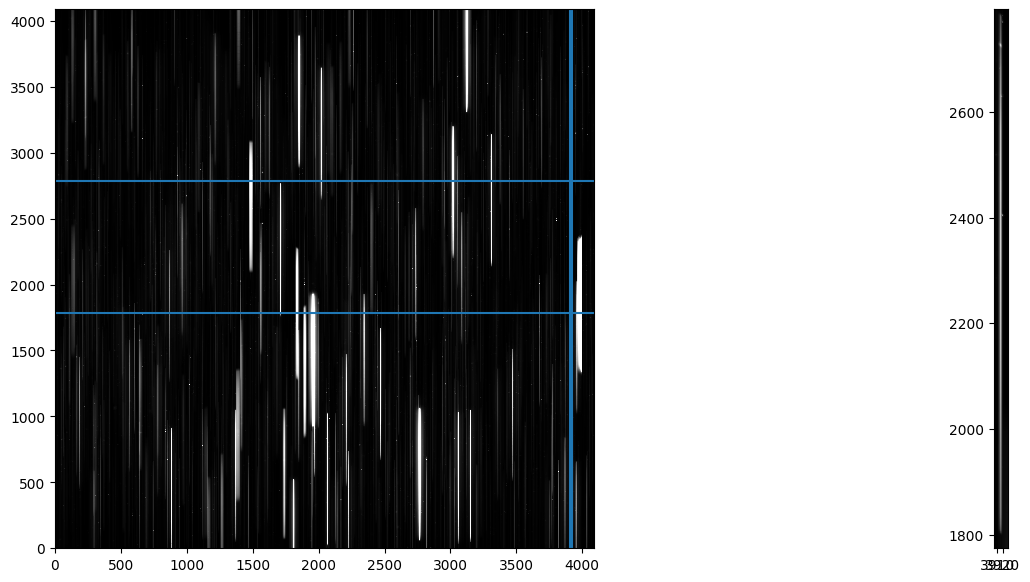

NUMBER  X_IMAGE   Y_IMAGE  A_IMAGE B_IMAGE THETA_IMAGE MAG_F1500W SPECTEMP    Z     MODIMAGE MODIMAGE_1 MODIMAGE_2
------ --------- --------- ------- ------- ----------- ---------- -------- -------- -------- ---------- ----------
110372 1483.2339 2581.3271 11.7312  9.4379       55.65      16.11   110372 0.083632        0  9.4755111 -0.7196574


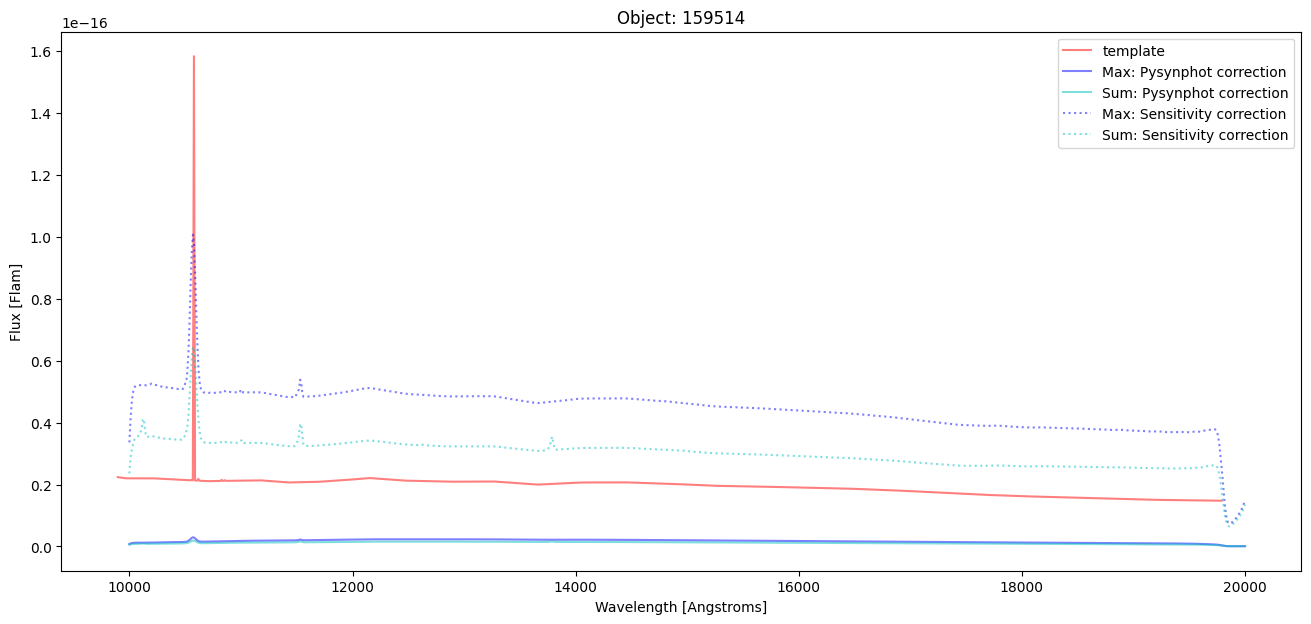

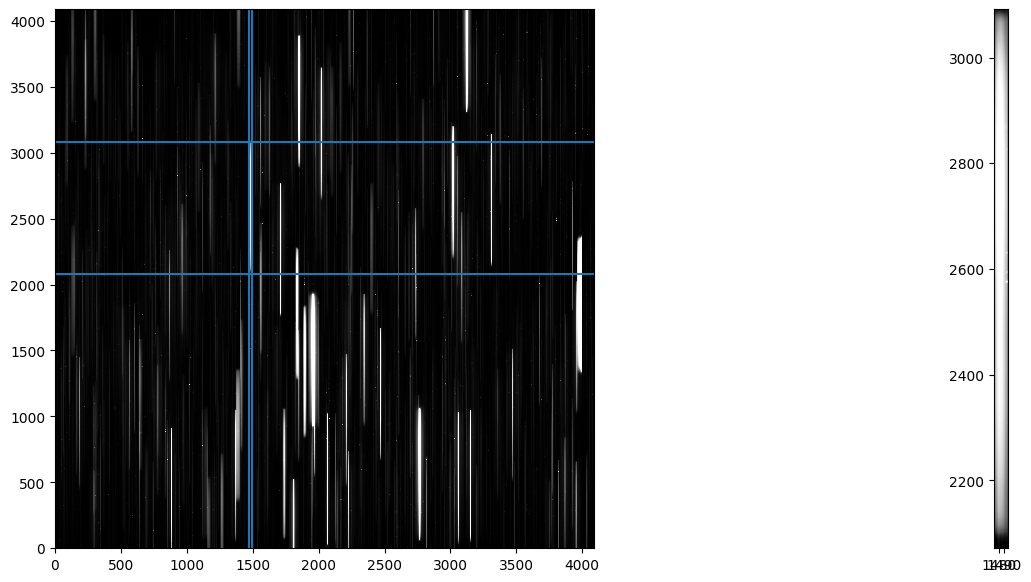

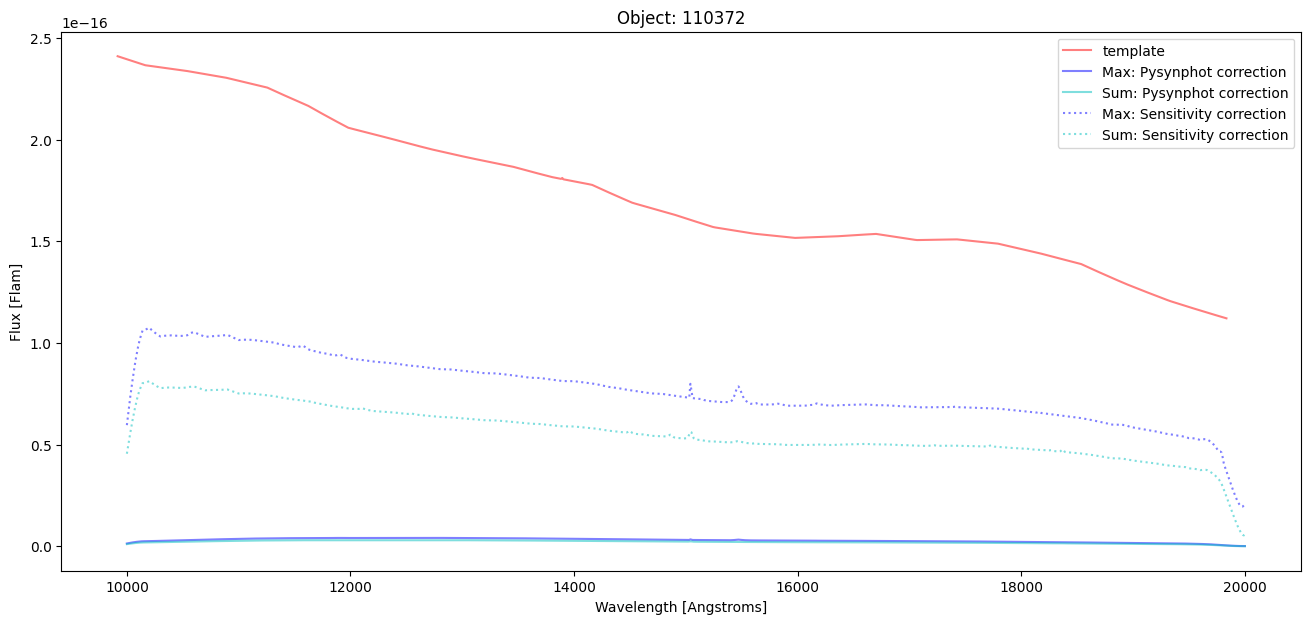

In [ ]:
x = [3916, 1484]
y = [2284, 2583]
half_width = [3, 15]

coords = Table({"x": x, "y": y, "half_width": half_width})

for coord in coords:
    object = find_object(coord.get("x"), coord.get("y"), 10)
    print(object)
    template = load_template(object)
    print_cutout(object)
    max_extract, sum_extract = extraction(object, half_width=coord.get("half_width"))
    max_spec = S_prep(max_extract)
    sum_spec = S_prep(sum_extract)
    max_corr_spec = sens_correct(max_extract)
    sum_corr_spec = sens_correct(sum_extract)

    plt.plot(template.wave, template.flux, c='r', alpha=0.5, label="template")
    plt.plot(max_spec.wave, max_spec.flux, c='b', alpha=0.5, label="Max: Pysynphot correction")
    plt.plot(sum_spec.wave, sum_spec.flux, c='c', alpha=0.5, label="Sum: Pysynphot correction")
    plt.plot(max_corr_spec["wave"], max_corr_spec["flux"], c='b', linestyle=':', alpha=0.5, label="Max: Sensitivity correction")
    plt.plot(sum_corr_spec["wave"], sum_corr_spec["flux"], c='c', linestyle=':', alpha=0.5, label="Sum: Sensitivity correction")

    plt.title(f"Object: {object["NUMBER"]}")
    plt.xlabel("Wavelength [Angstroms]")
    plt.ylabel("Flux [Flam]")
    plt.legend();